In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from matplotlib import rcParams
from numpy import mean, median, abs, sum, cumsum, histogram, sqrt

rcParams['font.size'] = 6

from C3SData.data import C3SD
from kmcm import KMCMulti, kmcm_p_grid

In [2]:
def metrics(model, data):
    """
metrics
    description:
        computes a standard set of performance metrics using a trained model and dataset
            * training and test set R-squared (R2)
            * training and test set root mean squared error (RMSE)
            * training and test set mean absolute error (MAE)
            * cumulative error distribution at the <1, <3, <5, and <10% levels
              for training and test set (CE135A)
"""
    summary = {}
    for s in ['train', 'test']:
        if s == 'train':
            y = data.y_train_
            y_pred = model.predict(data.X_train_ss_)
        if s == 'test':
            y = data.y_test_
            y_pred = model.predict(data.X_test_ss_)
            
        # compute metrics
        abs_y_err = abs(y_pred - y)
        r2 = r2_score(y, y_pred)
        mae = mean(abs_y_err)
        mdae = median(abs_y_err)
        rmse = sqrt(mean_squared_error(y, y_pred))
        y_err_percent = 100. * abs_y_err / y
        cum_err = cumsum(histogram(y_err_percent, [_ for _ in range(101)])[0])
        cum_err = 100. * cum_err / sum(cum_err)
        ce1, ce3, ce5, ceA = cum_err[0], cum_err[2], cum_err[4], cum_err[9]
        summary[s] = {'R2': r2, 'MAE': mae, 'MDAE': mdae, 'RMSE': rmse, 'CE135A': [ce1, ce3, ce5, ceA]}
    return summary
   
    
def summary_figure(summary, r2_range=[0.95, 1.], save=None):
    """
summary_figure
    description:
        produces a summary figure displaying the results from a trial
    parameters:
        [r2_range (list(float))] -- upper and lower bounds of R-squared y axis [optional, default=[0.95, 1.]]
        [save (None or str)] -- if a filename is provided, save the figure (optional, default=None)
""" 
    fig = plt.figure(figsize=(3.33, 1.75))
    gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 3, 5])
    
    # R-squared
    ax1 = fig.add_subplot(gs[0])
    rsq_trn = summary['train']['R2']
    rsq_tst = summary['test']['R2']
    w1 = 0.15
    ax1.bar([1 - w1 / 2, 1 + w1 / 2], [rsq_trn, rsq_tst], color=['b', 'r'], width=w1)
    for d in ['top', 'right']:
        ax1.spines[d].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylabel(r'R$^2$')
    ax1.set_ylim(r2_range)
    ax1.set_xlim([0.75, 1.25])
    
    # MAE, MDAE and RMSE
    ax2 = fig.add_subplot(gs[1])
    mae_trn = summary['train']['MAE']
    mae_tst = summary['test']['MAE']
    mdae_trn = summary['train']['MDAE']
    mdae_tst = summary['test']['MDAE']
    mse_trn = summary['train']['RMSE']
    mse_tst = summary['test']['RMSE']
    ax2.bar([0.875, 1.125], [mae_trn, mae_tst], color=['b', 'r'], width=0.25)
    ax2.bar([1.875, 2.125], [mdae_trn, mdae_tst], color=['b', 'r'], width=0.25)
    ax2.bar([2.875, 3.125], [mse_trn, mse_tst], color=['b', 'r'], width=0.25)
    for d in ['top', 'right']:
        ax2.spines[d].set_visible(False)
    ax2.set_xticks([1, 2, 3])
    ax2.set_xticklabels(['MAE', 'MDAE', 'RMSE'], rotation='vertical')
    ax2.set_ylabel(r'CCS (Å$^2$)')
    
    # CE135A
    ax3 = fig.add_subplot(gs[2])
    x1 = [_ - 0.125 for _ in range(1, 5)]
    y1 = [100. * summary['train']['CE135A'][i] for i in range(4)]
    x2 = [_ + 0.125 for _ in range(1, 5)]
    y2 = [100. * summary['test']['CE135A'][i] for i in range(4)]
    
    ax3.bar(x1, y1, color='b', width=0.25)
    ax3.bar(x2, y2, color='r', width=0.25)
    
    for d in ['top', 'right']:
        ax3.spines[d].set_visible(False)
    ax3.set_xlabel('pred. error (%)')
    ax3.set_xticks([1, 2, 3, 4])
    ax3.set_xticklabels(['<1', '<3', '<5', '<10'])
    ax3.set_ylabel('proportion (%)')

    
    plt.tight_layout()
    plt.savefig('kmcm_svr_final_perfsummary.png', dpi=400, bbox_inches='tight')
    plt.show()

In [5]:
data = C3SD('C3S.db', seed=2345)
data.featurize()
data.train_test_split('ccs')
data.center_and_scale()
kmcm_svr_p_grid = kmcm_p_grid([4], {'C': [4000, 8000, 16000], 'gamma': [0.0001, 0.0005, 0.001]})
kmcm_svr_gs = GridSearchCV(KMCMulti(seed=2345, use_estimator=SVR(cache_size=2048, tol=5e-4)), 
                           param_grid=kmcm_svr_p_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

In [6]:
kmcm_svr_gs.fit(data.X_train_ss_, data.y_train_)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KMCMulti(estimator_params=None, n_clusters=3, seed=2345,
                                use_estimator=SVR(C=1.0, cache_size=2048,
                                                  coef0=0.0, degree=3,
                                                  epsilon=0.1,
                                                  gamma='auto_deprecated',
                                                  kernel='rbf', max_iter=-1,
                                                  shrinking=True, tol=0.0005,
                                                  verbose=False)),
             iid='warn', n_jobs=-1,
             param_grid=[{'estimator_params': [[{'C': 4000, 'gamma': 0...
                                                {'C': 4000, 'gamma': 0.0001}],
                                               [{'C': 4000, 'gamma': 0.0001},
                                                {'C': 4000, 'gamma': 0.0001},
                  

In [7]:
kmcm_svr_best = kmcm_svr_gs.best_estimator_

In [8]:
kmcm_svr_gs.best_params_


{'estimator_params': [{'C': 16000, 'gamma': 0.001},
  {'C': 8000, 'gamma': 0.001},
  {'C': 16000, 'gamma': 0.0005},
  {'C': 16000, 'gamma': 0.0005}],
 'n_clusters': 4}

In [9]:
import json

    
summary = metrics(kmcm_svr_best, data)

with open('kmcm_svr_final_results.json', 'w') as f:
    json.dump(summary, f, indent=4)

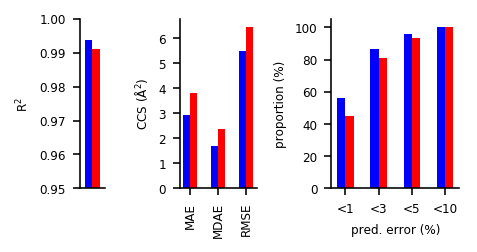

In [10]:
rcParams['font.size'] = 6
summary_figure(summary)

In [11]:
import pickle


with open('kmcm_svr_final_20200204.pickle', 'wb') as pf:
    pickle.dump(kmcm_svr_best, pf)
    
with open('OHEncoder_20200214.pickle', 'wb') as ohe, open('LEncoder_20200204.pickle', 'wb') as le, open('SScaler_20200204.pickle', 'wb') as ss:
    pickle.dump(data.OHEncoder_, ohe)
    pickle.dump(data.LEncoder_, le)
    pickle.dump(data.SScaler_, ss)


In [ ]:
import sklearn
print(sklearn.__version__)